In [1]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import pickle
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import activations
from keras.callbacks import CSVLogger
from tensorflow.keras.applications import MobileNet, MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

In [2]:

# ROOT_PATH = pathlib.Path(r"/kaggle/input/animal-ds")
DATASET_PATH = pathlib.Path('Dataset')
TRAINING_PATH = pathlib.Path(f'{DATASET_PATH}/train')
TEST_PATH = pathlib.Path(f'{DATASET_PATH}/valid')
# VALIDATION_PATH = pathlib.Path(f'{DATASET_PATH}/val')

In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32

In [4]:
CLASSES= os.listdir(TRAINING_PATH)

print(f"Classes: {CLASSES}")

Classes: ['Belimbing Sayur', 'Bunga Lawang', 'Jahe', 'Jeruk Nipis', 'Kunyit', 'Lengkuas', 'Mengkudu']


In [5]:
def train_test_generators(TRAINING_DIR, TEST_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1/255,
                                     rotation_range=10,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='sparse',
                                                      target_size=IMAGE_SIZE)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  test_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='sparse',
                                                              target_size=IMAGE_SIZE)

  return train_generator, test_generator

In [6]:
train_generator, test_generator = train_test_generators(TRAINING_PATH, TEST_PATH)

Found 2055 images belonging to 7 classes.


Found 487 images belonging to 7 classes.


In [7]:
base_model = MobileNetV2(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), include_top=False)

for layer in base_model.layers:
  layer.trainable = False

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'


In [8]:
def simple_model():
    model = tf.keras.models.Sequential([
        # Input the base pre trained model
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    return model

In [9]:
model = simple_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,294,983 (39.27 MB)

 Trainable params: 8,036,999 (30.66 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [11]:
# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',      # Metrik yang dipantau
#     factor=0.5,              # Faktor pengurangan learning rate
#     patience=5,              # Jumlah epoch tanpa peningkatan sebelum learning rate diturunkan
#     min_lr=1e-6              # Nilai learning rate minimum
# )

class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
       
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        
        if train_accuracy >= 0.95 and val_accuracy >= 0.85:
            self.model.stop_training = True

            print("\nReached 95% train accuracy and 85% validation accuracy, so cancelling training!")

In [12]:
epoch = 100
history = model.fit(train_generator, 
                    batch_size=BATCH_SIZE, 
                    epochs=epoch, 
                    validation_data=test_generator, 
                    shuffle=True,
                    callbacks = [EarlyStoppingCallback()])

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
18/65 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2964 - loss: 5.7457

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.4460 - loss: 4.1519 - val_accuracy: 0.8727 - val_loss: 0.4079
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6743 - loss: 1.0051 - val_accuracy: 0.8932 - val_loss: 0.3475
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7769 - loss: 0.7713 - val_accuracy: 0.8953 - val_loss: 0.4134
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 65s 997ms/step - accuracy: 0.7811 - loss: 0.7122 - val_accuracy: 0.9097 - val_loss: 0.2943
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 65s 998ms/step - accuracy: 0.7873 - loss: 0.6949 - val_accuracy: 0.9035 - val_loss: 0.3041
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8152 - loss: 0.6108 - val_accuracy: 0.9281 - val_loss: 0.2918
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8118 - loss: 0.5641 - val_accuracy: 0.8973 - val_loss: 0.2875
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8251 - loss: 0.5463 - val_accuracy: 0.9117 - val_los

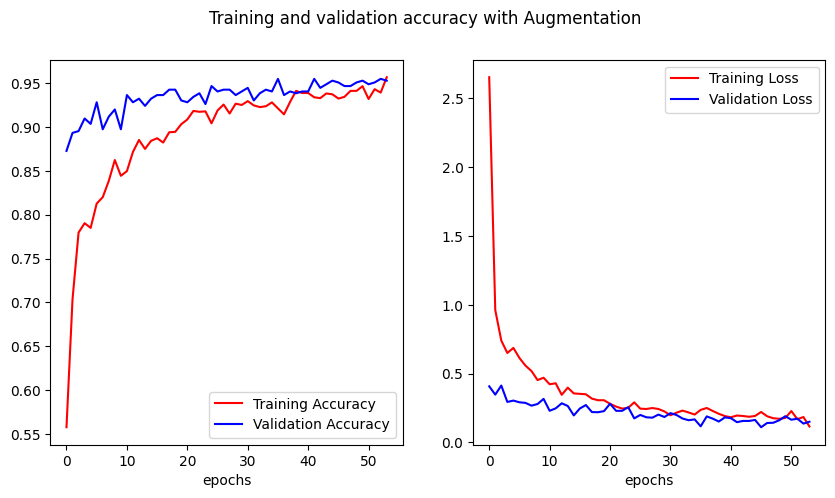

In [13]:

# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy with Augmentation')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [15]:

# Get true labels and predictions for the augmented model
y_true_aug = np.concatenate([y for x, y in test_generator], axis=0)
y_pred_aug = model.predict(test_generator)
y_pred_classes_aug = np.argmax(y_pred_aug, axis=1)
y_true_classes_aug = np.argmax(y_true_aug, axis=1)

# Create confusion matrix for the augmented model
conf_matrix_aug = confusion_matrix(y_true_classes_aug, y_pred_classes_aug)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix with Data Augmentation')
    plt.show()

# Plot the confusion matrix with class labels
class_names = ['Belimbing Sayur',  'Bunga Lawang','Jahe', 'Jeruk Nipis', 'Kunyit', '"Lengkuas']
plot_confusion_matrix(conf_matrix_aug, class_names)

KeyboardInterrupt: 

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
save_dir = r'Dataset'
model_name = 'LokaJamu'
subject = 'LokaJamu'

# Simplified and more descriptive variable names
num_test_files = sum([len(files) for r, d, files in os.walk(TEST_PATH)])
num_test_steps = num_test_files // BATCH_SIZE

# Evaluate the model and print the message
test_datagen = ImageDataGenerator(rescale=1./255)  # Adjust preprocessing as needed
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),  # replace with your model's input dimensions
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='sparse')
acc = model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=1, steps=num_test_steps)[1] * 100
print(f"Accuracy on the test set is {acc:.2f} %")

# Save the model
model_id = f"{model_name}-{subject}.h5"

# Check if the directory exists, if not, create it
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)

model.save('lokajamu_model.h5')

# pickle.dump(model,open(model_id,"wb"))


Found 417 images belonging to 7 classes.


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - accuracy: 0.9600 - loss: 0.1345


Accuracy on the test set is 94.71 %


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 567ms/step


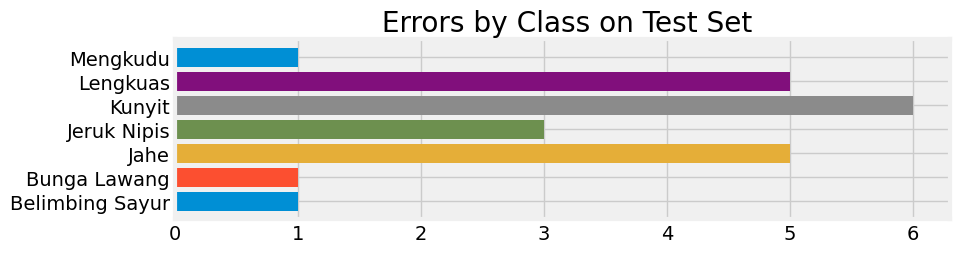

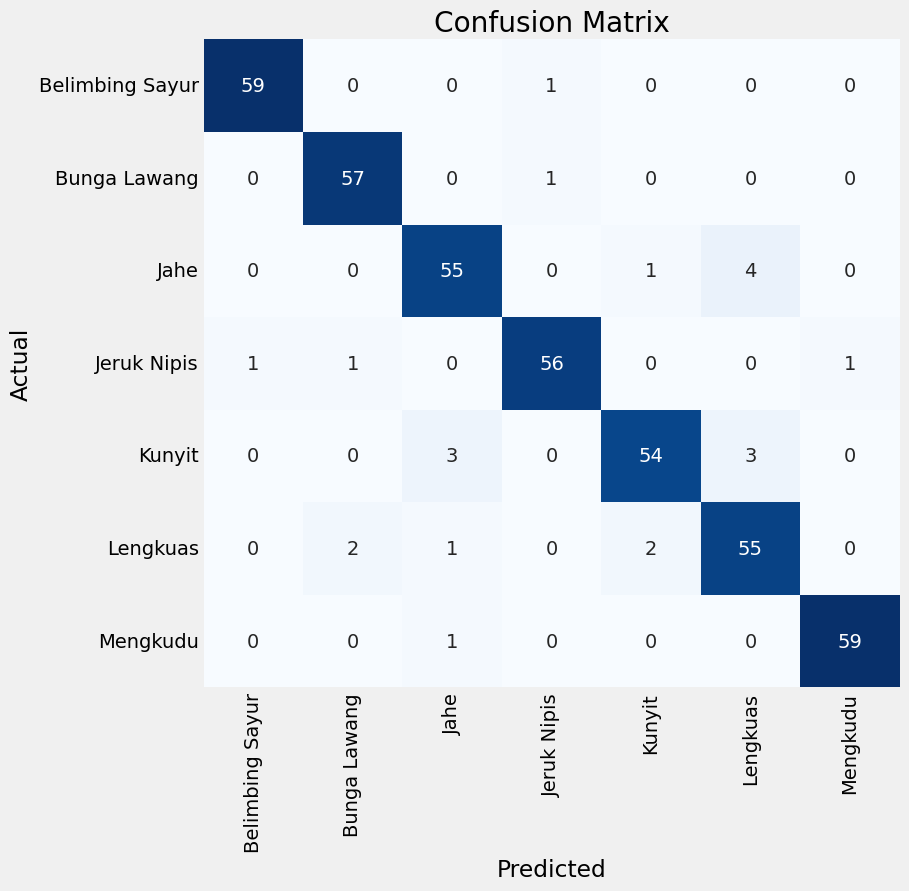

Classification Report:
----------------------
                  precision    recall  f1-score   support

Belimbing Sayur       0.98      0.98      0.98        60
   Bunga Lawang       0.95      0.98      0.97        58
           Jahe       0.92      0.92      0.92        60
    Jeruk Nipis       0.97      0.95      0.96        59
         Kunyit       0.95      0.90      0.92        60
       Lengkuas       0.89      0.92      0.90        60
       Mengkudu       0.98      0.98      0.98        60

       accuracy                           0.95       417
      macro avg       0.95      0.95      0.95       417
   weighted avg       0.95      0.95      0.95       417



In [ ]:
print_code=0
preds=model.predict(test_generator)
print_info( test_generator, preds, print_code, save_dir, subject )